In [91]:
import warnings
warnings.filterwarnings('ignore')

In [92]:
from libs.MSCTDdataset import MSCTD
from torch.utils.data import Dataset, DataLoader
from libs.transforms import Compose,toTensor,resize
from torchvision.transforms import ToTensor, Resize
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, Resize, Compose
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import PIL 
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sb


# Pre-Processing 

In [93]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/user01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/user01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user01/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user01/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [94]:
transforms = Compose([resize(dstsize=(224,224))])

root_dir = '.'

training_data_single = MSCTD(
        mode='train', 
        transformer=transforms,
        download=False,
        root_dir=root_dir,
        read_mode="single")

valid_data_single = MSCTD(
        mode='validation',
        transformer=transforms,
        download=False,
        root_dir=root_dir,
        read_mode="single")

test_data_single = MSCTD(
        mode='test',
        transformer=transforms,
        download=False,
        root_dir=root_dir,
        read_mode="single")

In [95]:
batch_size = 32
train_dataloader = DataLoader(training_data_single, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data_single, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data_single, batch_size=batch_size, shuffle=True)

In [96]:
# training Dataframe
training_data_sentiment = [int(i) for i in training_data_single.sentiment]
training_data = pd.DataFrame( data = {'sentences': training_data_single.english_text , 'sentiment': training_data_sentiment})

# training Dataframe
valid_data_sentiment = [int(i) for i in valid_data_single.sentiment]
valid_data = pd.DataFrame( data = {'sentences': valid_data_single.english_text , 'sentiment': valid_data_sentiment})

# test Dataframe
test_data_sentiment = [int(i) for i in test_data_single.sentiment]
test_data = pd.DataFrame( data = {'sentences': test_data_single.english_text , 'sentiment': test_data_sentiment})

In [97]:
# pre-processing function
def prep(review):
    
    # Remove non-letters
    review = re.sub("[^a-zA-Z]", " ", review)
    
    # Lower case
    review = review.lower()

    # Remove extra spaces
    review = re.sub(' +', ' ', review)
    
    # Tokenize to each word.
    token = nltk.word_tokenize(review)

    # Remove Stopwords
    stop = stopwords.words('english')
    review = [w for w in token if w not in stop]

    # Stemming
    review = [nltk.stem.SnowballStemmer('english').stem(w) for w in review]


    # lemmatization 
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(w) for w in review]

    # Join the words back into one string separated by space, and return the result.
    return " ".join(review)
    

In [98]:
training_data['clean'] = training_data['sentences'].apply(prep)
valid_data['clean'] = valid_data['sentences'].apply(prep)
test_data['clean'] = test_data['sentences'].apply(prep)

In [99]:
training_data

,sentences,sentiment,clean
0,Okay. I'm confused.,0,okay confus
1,"You don't care if I go to Paris with Jane,",0,care go pari jane
2,"I'm sorry. I have to tell you something,",1,sorri tell someth
3,I have to go.,1,go
4,I'm an accessory to murder.,1,accessori murder
...,...,...,...
20235,"Hey, this is for charity.",2,hey chariti
20236,You know you're taking those jeans out of the ...,0,know take jean hand
20237,"You know they're not getting the actual jeans,...",0,know get actual jean right luke
20238,"Oh. Right. Well, then how about a donation?",2,oh right well donat


In [100]:
valid_data

,sentences,sentiment,clean
0,He diagnosed Andy with growing pains.,0,diagnos andi grow pain
1,"But, you know, I grew up,",0,know grew
2,Your pain is dramatic to me.,1,pain dramat
3,Andy. your mom's right.,0,andi mom right
4,It's a good thing that you came.,0,good thing came
...,...,...,...
5058,Your van crashed.,1,van crash
5059,"No one was hurt, but we need to get you examined.",2,one hurt need get examin
5060,Come on.,1,come
5061,I must have fallen asleep at the wheel for a s...,2,must fallen asleep wheel second


In [101]:
test_data

,sentences,sentiment,clean
0,With this asshole?,1,asshol
1,"Two guys walk in, one walks out.",1,two guy walk one walk
2,"I'm not happy about it either, okay? At all.",1,happi either okay
3,"But, for now, it's done.",1,done
4,You're on admin leave until they make a determ...,0,admin leav make determin batteri
...,...,...,...
5062,"Han, you stand there and try to look smart.",2,han stand tri look smart
5063,"Ah. I'm already Asian. So, done.",2,ah alreadi asian done
5064,"Wow, this brings me back.",0,wow bring back
5065,"I had a seat at the popular table,",0,seat popular tabl


# A) Creating Word Embeddings 

## Part 1: TF-IDF

`TF-IDF` can be used as a method of creating word embeddings, by representing each word as a vector of its TF-IDF weights across a corpus of documents. This can be useful in NLP tasks where the importance of a word in a document is important, such as document classification or information retrieval.
TF-IDF word embeddings are typically sparse and high-dimensional, as each word is represented by a large number of weights, one for each document in the corpus.

In TF-IDF, **the term frequency `(TF)`** measures the number of times a word appears in a document, while the **inverse document frequency `(IDF)`** measures how frequently the word appears across the entire corpus of documents. The product of these two measures gives a weight to each word, reflecting its importance in the document relative to the entire corpus.

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words
from wordcloud import WordCloud, STOPWORDS


In [103]:
tv = TfidfVectorizer(ngram_range = (1,3), sublinear_tf = True, max_features = 40000)

In [104]:
train_tv = tv.fit_transform(training_data['clean'])
test_tv = tv.transform(test_data['clean'])

In [105]:
vocab = tv.get_feature_names_out()
vocab

array(['aaron', 'abdomen', 'abl', ..., 'zuckerberg', 'zup', 'zz'],
      dtype=object)

In [106]:
dist = np.sum(train_tv, axis=0)
checking = pd.DataFrame(dist,columns = vocab)

In [107]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

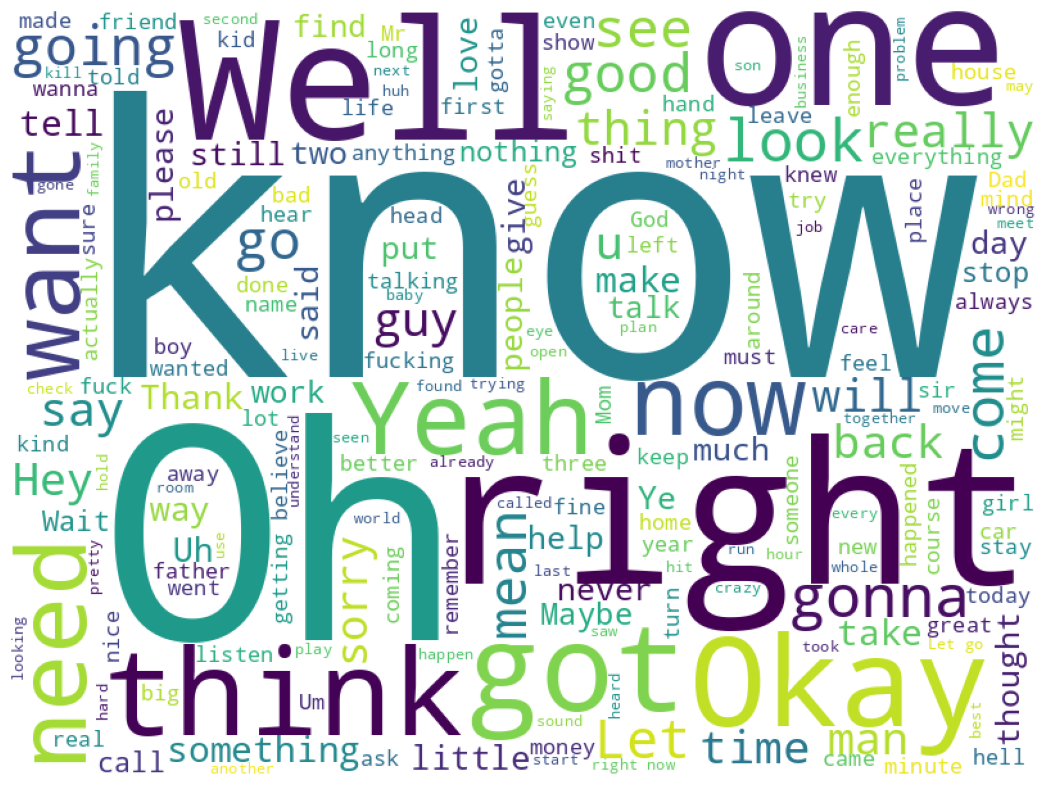

In [108]:
cloud(' '.join(training_data['sentences']))

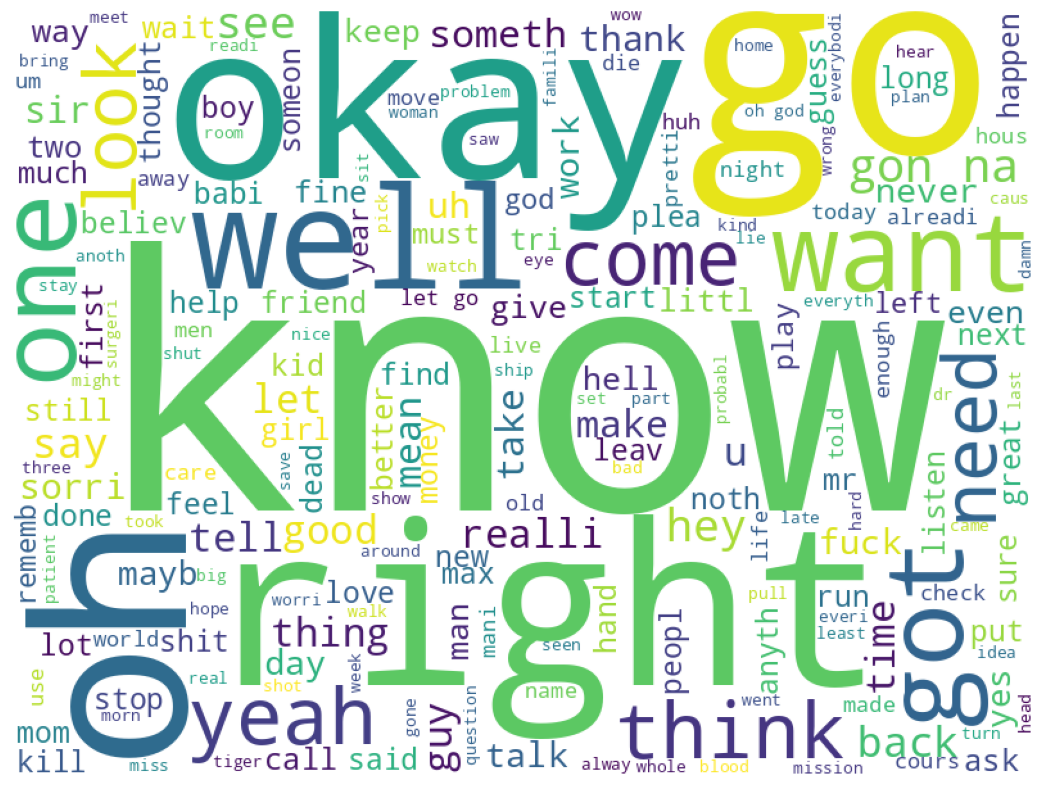

In [109]:
cloud(' '.join(test_data['clean']))

* SVM

In [110]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(train_tv, training_data['sentiment'])
y_pred=clf.predict(test_tv)

In [111]:
print(classification_report(y_true=test_data['sentiment'], y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.35      0.49      0.41      1298
    negative       0.56      0.54      0.55      2163
    positive       0.53      0.40      0.45      1606

    accuracy                           0.48      5067
   macro avg       0.48      0.47      0.47      5067
weighted avg       0.50      0.48      0.48      5067



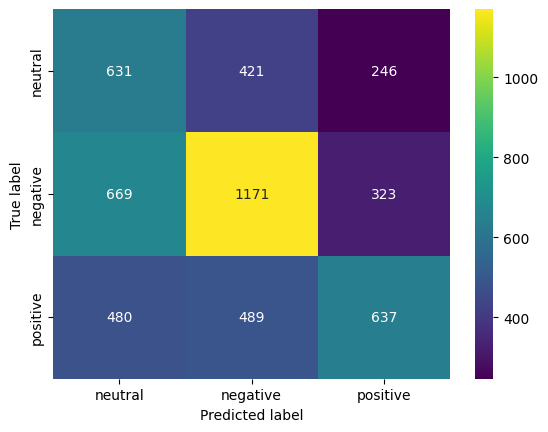

In [112]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* Logistic Regression

In [113]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000,solver='saga')
clf.fit(train_tv, training_data['sentiment'])
y_pred=clf.predict(test_tv)

In [114]:
print(classification_report(y_true=test_data['sentiment'], y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.37      0.51      0.43      1298
    negative       0.56      0.58      0.57      2163
    positive       0.57      0.38      0.45      1606

    accuracy                           0.50      5067
   macro avg       0.50      0.49      0.48      5067
weighted avg       0.52      0.50      0.50      5067



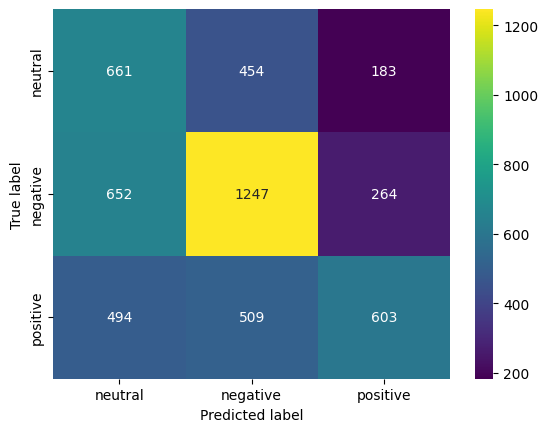

In [115]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* MLP

In [116]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=1000, activation = 'relu', solver='adam', random_state=1)
clf.fit(train_tv, training_data['sentiment'])
y_pred=clf.predict(test_tv)

In [117]:
print(classification_report(y_true=test_data['sentiment'], y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.33      0.48      0.39      1298
    negative       0.54      0.47      0.50      2163
    positive       0.47      0.38      0.42      1606

    accuracy                           0.44      5067
   macro avg       0.45      0.44      0.44      5067
weighted avg       0.46      0.44      0.45      5067



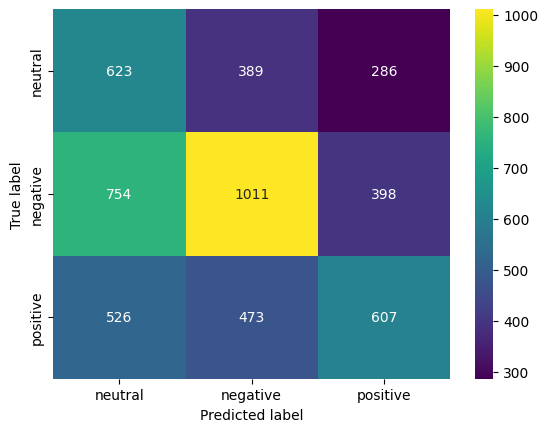

In [118]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Part 2: Word2Vec

In this part we use the `tf-idf` vector representation of each sentence to extract work representation.\
Then use this representation to train the `svm` classifier for each word as an embedding vector of that word
For training we select a word and its sentences as `positive` and other sentences that exclude that word select words from them as `negative`. For each word some svm may be trained to choose just one by taking the mean between them.

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [120]:
def get_feature(data,analyze,vocab):
  a=[]
  for i in list(map(analyze,data)):
    b=[]
    for j in i:
      if j in vocab:
        b.append(j)
    a.append(b)
  return a
  
tv = TfidfVectorizer(ngram_range = (1,1), sublinear_tf = True,stop_words='english', max_features = 1000)
Xtrain_tv = tv.fit_transform(training_data['clean'])
Xtest_tv = tv.transform(test_data['clean'])
analyze = tv.build_analyzer()
vocab = tv.get_feature_names_out ()
training_data['feature'] = get_feature(training_data['clean'].values,analyze,vocab) 
test_data['feature'] = get_feature(test_data['clean'].values,analyze,vocab) 

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


class sudoWord2Vec:
  def __init__(self,Dataset_train:pd.DataFrame,Dataset_test:pd.DataFrame,Xtrain_tv,Xtest_tv,tv):
    self.Dataset_train=Dataset_train
    self.Dataset_test=Dataset_test

    self.Xtrain_tv = Xtrain_tv
    self.Xtest_tv = Xtest_tv
    self.tv = tv

    self.scaler = StandardScaler()

    self.svd_train = TruncatedSVD(n_components=250, n_iter=7, random_state=42)
    self.svd_test = TruncatedSVD(n_components=250, n_iter=7, random_state=42)
    self.Xtrain_tv_reduced = self.scaler.fit_transform(self.svd_train.fit_transform(self.Xtrain_tv.transpose()))
    self.Xtest_tv_reduced = self.scaler.fit_transform(self.svd_test.fit_transform(self.Xtest_tv.transpose()))

    self.vocab = self.tv.get_feature_names_out ()
    
  def run_svd(self,query_vocab):
    
    include_list=self.Dataset_train[list(map(lambda x: query_vocab in x,self.Dataset_train['feature'].values))]['feature'].values
    exclude_list=self.Dataset_train[list(map(lambda x: query_vocab not in x,self.Dataset_train['feature'].values))]['feature'].values
    Xt=self.Xtrain_tv_reduced

    minus_list=np.array(list(set(np.concatenate(exclude_list).tolist())))

    W=[]
    b=[]
    y_pred=[]
    y_true=[]
    for i in include_list:
      self.clf = LinearSVC(random_state=0,C=1e-1,dual=False)
      l=len(i)

      minus_selected=minus_list[np.random.randint(0,len(minus_list),size=(l)).tolist()]

      X_plus=Xt[np.array(np.where(self.vocab==np.array(i)[:,None].tolist())[1]).reshape(-1,)]
      X_minus=Xt[np.array(np.where(self.vocab==minus_selected[:,None].tolist())[1]).reshape(-1,)]

      y_plus=np.ones(len(X_plus))
      y_minus=np.ones(len(X_minus))*-1
 
      X_total=np.concatenate((X_plus,X_minus))

      y_total=np.concatenate((y_plus,y_minus))
      self.clf.fit(X_total,y_total)
      
      W.append(self.clf.coef_)
      b.append(self.clf.intercept_)
     
      
      y_pred.append(self.clf.predict(X_total))
      y_true.append(y_total)
    
    return np.mean(W,axis=0).T,np.mean(b)

  def run_test(self,Result):
    
    query_vocab= Result[0]
    W=Result[1][0]
    b=Result[1][1]

    include_list=self.Dataset_test[list(map(lambda x: query_vocab in x,self.Dataset_test['feature'].values))]['feature'].values
    exclude_list=self.Dataset_test[list(map(lambda x: query_vocab not in x and len(x)>0,self.Dataset_test['feature'].values))]['feature'].values
        
    Xt=self.Xtest_tv_reduced

    minus_list=np.array(list(set(np.concatenate(exclude_list).tolist())))

    y_pred=[]
    y_true=[]
    for i in include_list:
      l=len(i)
      
      
      minus_selected=minus_list[np.random.randint(0,len(minus_list),size=(l)).tolist()]
      
      X_plus=Xt[np.array(np.where(self.vocab==np.array(i)[:,None].tolist())).reshape(-1,)]
      X_minus=Xt[np.array(np.where(self.vocab==np.array(minus_selected)[:,None].tolist())).reshape(-1,)]

      y_plus=np.ones(len(X_plus))
      y_minus=np.ones(len(X_minus))*-1

      X_total=np.concatenate((X_plus,X_minus))

      y_total=np.concatenate((y_plus,y_minus))
      
      
      
      y_pred.append(np.sign(X_total@W +b))
      y_true.append(y_total)
    if len(y_true):
      return np.concatenate(y_true).reshape(-1,),np.concatenate(y_pred).reshape(-1,)

    else :
      return np.array([]),np.array([])
  
  def run_total_vocab(self):
    Result=[]
   
    print("Run on Train ....")
    for i in tqdm(self.vocab):
      param=self.run_svd(i)
      Result.append((i,param))
    return Result

  def run_test_total(self,Result):
    y_true_test=[]
    y_pred_test=[]
    print("Run on Test ....")
    for i in tqdm(range(len(Result))):
      a,b=self.run_test(Result[i])
      y_true_test.append(a)
      y_pred_test.append(b)
    print(classification_report(np.concatenate(y_true_test).reshape(-1,),np.concatenate(y_pred_test).reshape(-1,)))
    return np.concatenate(y_true_test).reshape(-1,),np.concatenate(y_pred_test).reshape(-1,)

 

In [122]:
A=sudoWord2Vec(training_data,test_data,Xtrain_tv,Xtest_tv,tv)

In [123]:
Result=A.run_total_vocab()

Run on Train ....


100%|██████████| 1000/1000 [00:54<00:00, 18.41it/s]


In [124]:
A.run_test_total(Result)

Run on Test ....


100%|██████████| 1000/1000 [00:06<00:00, 147.94it/s]


              precision    recall  f1-score   support

        -1.0       0.53      0.89      0.66     50646
         1.0       0.66      0.22      0.32     50646

    accuracy                           0.55    101292
   macro avg       0.60      0.55      0.49    101292
weighted avg       0.60      0.55      0.49    101292



(array([ 1.,  1.,  1., ..., -1., -1., -1.]),
 array([ 1.,  1., -1., ...,  1., -1.,  1.]))

### training RNN to predict class of each sentences

After training each word classifier we make `GRU` model that takes embedding as input for each word in sentences then produce correspond logits class

In [125]:
def tensorFromSentence(Result, sentence):
  feature_list=[]
  for i in sentence:
    w,b=Result[i]

    feature_list.append(torch.tensor(np.concatenate((w[:,0],np.array([b]))))[None,:])
  if len(feature_list)>1:
    return torch.concatenate(feature_list,).to(device)
  elif len(feature_list)==1:
    return feature_list[0].to(device)
  else :
    return torch.tensor([]).to(device)

In [126]:
class ClsRnnNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ClsRnnNetwork, self).__init__()
        self.hidden_size = hidden_size

        # self.embedding = nn.Embedding(input_size, hidden_size)

        self.gru = nn.GRU(input_size, hidden_size)
        self.cls = nn.Sequential(OrderedDict([
          ('FC1', nn.Linear(in_features=251,out_features=125)),
          ('relu1', nn.ReLU()),
          ('dropout',nn.Dropout(p=0.5)),
          ('Fc2', nn.Linear(in_features=125,out_features=3))
        ]))

    def forward(self, input):
        # embedded = self.embedding(input).view(1, 1, -1)
        # output = embedded
        for i in input:
          output, _ = self.gru(i.view(1, 1, -1))
          
        logits=self.cls(output)
        
        return logits

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [127]:
def clacModel(model, input_tensor, target_class, model_optimizer, criterion):

   model_optimizer.zero_grad()

   input_length = input_tensor.size(0)
   loss = 0
   epoch_loss = 0
   correct = 0

   
   output = model(input_tensor)
#calculate the loss from a predicted sentence with the expected result

   loss += criterion(output[0], target_class.view(1))
   pred = torch.argmax(output[0])
   correct = 1 if pred==target_class else 0
   
   loss.backward()
   model_optimizer.step()
   epoch_loss = loss.item()

   return epoch_loss,correct

In [128]:
def trainModel(model,Dataset_train,Dataset_test, Result, num_iteration=20,type='GRU'):
   Result_dict=dict(Result)
   
   

  
   optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)
   criterion = nn.CrossEntropyLoss()

   total_loss_iterations = 0
   final_score = 0
   total_correct = 0
   counter = 0
   training_tensors = [tensorFromSentence(Result_dict,Dataset_train['feature'][i]) for i in range(len(Dataset_train))]
   test_tensors = [tensorFromSentence(Result_dict,Dataset_train['feature'][i]) for i in range(len(Dataset_test))]
   sentiments_train = Dataset_train['sentiment']
   sentiments_test = Dataset_test['sentiment']
   for epochs in tqdm(range(num_iteration)):
    total_loss_iterations = 0
    counter = 0
    total_correct = 0
    model.train()
    for iter in range(len(Dataset_train)):
        input_tensor = training_tensors[iter].float()
        target_class = torch.tensor(sentiments_train[iter]).to(device)

        if len(input_tensor) == 0:
          continue
        counter+=1
        loss,correct = clacModel(model, input_tensor, target_class, optimizer, criterion)
        
        total_correct += correct
        total_loss_iterations += loss
        
    
    avarage_loss= total_loss_iterations / counter
    avg_acc = total_correct /counter
    tqdm.write(f'iter :{iter} , Loss : {avarage_loss} , Acc :{avg_acc*100}')
    #  scheduler.step()
    torch.save(model.state_dict(), f'checkpoints/phase2_2_{type}_Model.pt')
    # test
    model.eval()
    prediction =[]
    total_loss_iterations = 0
    counter = 0
    total_correct = 0
    for iter in range(len(Dataset_test)):
        input_tensor = training_tensors[iter].float()
        target_class = torch.tensor(sentiments_test[iter]).to(device)
        counter+=1
        if len(input_tensor) == 0:
          output = torch.randn(size=(1,1,3)).to(device)
        else :
          output = model(input_tensor)

        total_loss_iterations += criterion(output[0], target_class.view(1))
        
        pred = torch.argmax(output[0])
        prediction.append(pred)
        correct = 1 if pred==target_class else 0

        total_correct += correct
       

    avarage_loss= total_loss_iterations / counter
    avg_acc = total_correct /counter
    tqdm.write(f'Loss test : {avarage_loss} , Acc test :{avg_acc*100}')


          
   return model,prediction

In [129]:
model =ClsRnnNetwork(251,251)
model.to(device)
model,prediction=trainModel(model,training_data,test_data,Result)

  0%|          | 0/20 [00:25<?, ?it/s]

iter :20239 , Loss : 1.0485743365796585 , Acc :45.39329627758127


  5%|▌         | 1/20 [00:27<08:51, 27.98s/it]

Loss test : 1.112200140953064 , Acc test :41.42490625616736


  5%|▌         | 1/20 [00:53<08:51, 27.98s/it]

iter :20239 , Loss : 1.0420229125629485 , Acc :46.62287350513728


 10%|█         | 2/20 [00:55<08:16, 27.59s/it]

Loss test : 1.1148779392242432 , Acc test :41.83935267416617


 10%|█         | 2/20 [01:21<08:16, 27.59s/it]

iter :20239 , Loss : 1.0362573283485577 , Acc :46.97658750210544


 15%|█▌        | 3/20 [01:23<07:52, 27.77s/it]

Loss test : 1.1255165338516235 , Acc test :40.517071245312806


 15%|█▌        | 3/20 [01:48<07:52, 27.77s/it]

iter :20239 , Loss : 1.028818702144618 , Acc :47.319072483296836


 20%|██        | 4/20 [01:50<07:18, 27.41s/it]

Loss test : 1.124561071395874 , Acc test :40.852575488454704


 20%|██        | 4/20 [02:15<07:18, 27.41s/it]

iter :20239 , Loss : 1.0222101318959238 , Acc :48.23985177699175


 25%|██▌       | 5/20 [02:17<06:48, 27.26s/it]

Loss test : 1.136194109916687 , Acc test :39.88553384645747


 25%|██▌       | 5/20 [02:41<06:48, 27.26s/it]

iter :20239 , Loss : 1.0187450518254233 , Acc :48.90797821570939


 30%|███       | 6/20 [02:44<06:20, 27.16s/it]

Loss test : 1.1325095891952515 , Acc test :40.18156700217091


 30%|███       | 6/20 [03:09<06:20, 27.16s/it]

iter :20239 , Loss : 1.0165371850555858 , Acc :49.149402054909885


 35%|███▌      | 7/20 [03:10<05:51, 27.06s/it]

Loss test : 1.1370853185653687 , Acc test :40.142095914742455


 35%|███▌      | 7/20 [03:35<05:51, 27.06s/it]

iter :20239 , Loss : 1.0146053171955645 , Acc :49.40766941777553


 40%|████      | 8/20 [03:37<05:23, 26.92s/it]

Loss test : 1.1353095769882202 , Acc test :39.905269390171696


 40%|████      | 8/20 [04:03<05:23, 26.92s/it]

iter :20239 , Loss : 1.0123823019515121 , Acc :49.44697097299422


 45%|████▌     | 9/20 [04:05<04:58, 27.10s/it]

Loss test : 1.1332218647003174 , Acc test :40.08288928359976


 45%|████▌     | 9/20 [04:30<04:58, 27.10s/it]

iter :20239 , Loss : 1.008596695211885 , Acc :49.969120206613894


 50%|█████     | 10/20 [04:32<04:32, 27.21s/it]

Loss test : 1.132016897201538 , Acc test :39.5697651470298


 50%|█████     | 10/20 [04:58<04:32, 27.21s/it]

iter :20239 , Loss : 1.0086028151083715 , Acc :50.00280725394419


 55%|█████▌    | 11/20 [04:59<04:05, 27.26s/it]

Loss test : 1.1377604007720947 , Acc test :38.74087231103217


 55%|█████▌    | 11/20 [05:25<04:05, 27.26s/it]

iter :20239 , Loss : 1.00427829972809 , Acc :50.49688394812195


 60%|██████    | 12/20 [05:27<03:37, 27.21s/it]

Loss test : 1.1477487087249756 , Acc test :38.7606078547464


 60%|██████    | 12/20 [05:52<03:37, 27.21s/it]

iter :20239 , Loss : 1.0050356170355714 , Acc :50.401437314019425


 65%|██████▌   | 13/20 [05:54<03:11, 27.33s/it]

Loss test : 1.143376350402832 , Acc test :39.33293862245905


 65%|██████▌   | 13/20 [06:19<03:11, 27.33s/it]

iter :20239 , Loss : 1.0025986909391966 , Acc :50.12071191960025


 70%|███████   | 14/20 [06:21<02:42, 27.16s/it]

Loss test : 1.148924469947815 , Acc test :39.39214525360173


 70%|███████   | 14/20 [06:46<02:42, 27.16s/it]

iter :20239 , Loss : 1.0017440171132577 , Acc :50.468811408680025


 75%|███████▌  | 15/20 [06:48<02:16, 27.29s/it]

Loss test : 1.1388983726501465 , Acc test :40.142095914742455


 75%|███████▌  | 15/20 [07:14<02:16, 27.29s/it]

iter :20239 , Loss : 1.0015196543614484 , Acc :50.693391724215374


 80%|████████  | 16/20 [07:16<01:49, 27.48s/it]

Loss test : 1.149122714996338 , Acc test :39.33293862245905


 80%|████████  | 16/20 [07:41<01:49, 27.48s/it]

iter :20239 , Loss : 1.00146393778454 , Acc :50.463196900791644


 85%|████████▌ | 17/20 [07:43<01:22, 27.35s/it]

Loss test : 1.1464046239852905 , Acc test :39.55002960331557


 85%|████████▌ | 17/20 [08:09<01:22, 27.35s/it]

iter :20239 , Loss : 0.9994306038083014 , Acc :50.844983437201726


 90%|█████████ | 18/20 [08:10<00:54, 27.23s/it]

Loss test : 1.1593267917633057 , Acc test :38.72113676731794


 90%|█████████ | 18/20 [08:35<00:54, 27.23s/it]

iter :20239 , Loss : 0.9993298129345791 , Acc :50.906743023973945


 95%|█████████▌| 19/20 [08:37<00:27, 27.13s/it]

Loss test : 1.1548601388931274 , Acc test :38.484310242747185


 95%|█████████▌| 19/20 [09:02<00:27, 27.13s/it]

iter :20239 , Loss : 0.9992438510956443 , Acc :51.03026219751838


100%|██████████| 20/20 [09:04<00:00, 27.24s/it]

Loss test : 1.154402494430542 , Acc test :39.668442865600944


In [130]:
print(classification_report(y_true=test_data['sentiment'], y_pred=torch.tensor(prediction), target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.25      0.10      0.15      1298
    negative       0.43      0.78      0.55      2163
    positive       0.31      0.12      0.17      1606

    accuracy                           0.40      5067
   macro avg       0.33      0.33      0.29      5067
weighted avg       0.35      0.40      0.33      5067



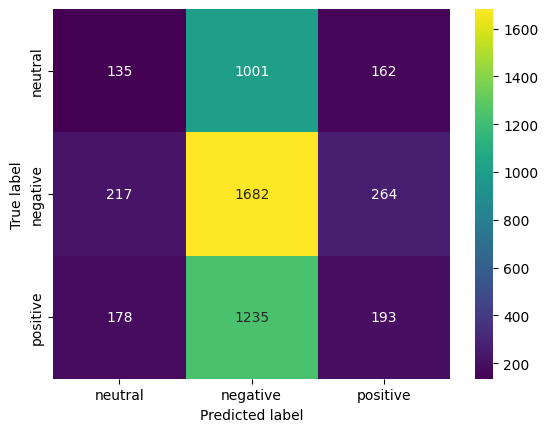

In [131]:
cf_matrix = confusion_matrix(y_true=test_data['sentiment'], y_pred=torch.tensor(prediction))

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# B) Pre-trained word embeddings : GloVe

**`GloVe` (Global Vectors for Word Representation)** is a method for creating word embeddings that represent words as dense vectors in a high-dimensional space. GloVe is trained on a large corpus of text data to learn the co-occurrence statistics between words, and it represents words as vectors of real numbers based on their co-occurrence patterns. GloVe is a fast and efficient method for creating word embeddings, but it does not take into account the context in which words appear.

In [132]:
import torchtext
from libs.glove import GloVe

In [133]:
glove = torchtext.vocab.GloVe(name='6B',dim=50)

In [134]:
vectorizer = GloVe(glove_dir='.vector_cache/glove.6B.50d.txt')

Xtrain = vectorizer.fit_transform(training_data.clean)
Ytrain = training_data.sentiment

Xtest = vectorizer.transform(test_data.clean)
Ytest = test_data.sentiment

* SVM

In [135]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(Xtrain, Ytrain)
y_pred=clf.predict(Xtest)

In [136]:
print(classification_report(y_true=Ytest, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.33      0.46      0.39      1298
    negative       0.51      0.59      0.55      2163
    positive       0.55      0.28      0.38      1606

    accuracy                           0.46      5067
   macro avg       0.47      0.44      0.44      5067
weighted avg       0.48      0.46      0.45      5067



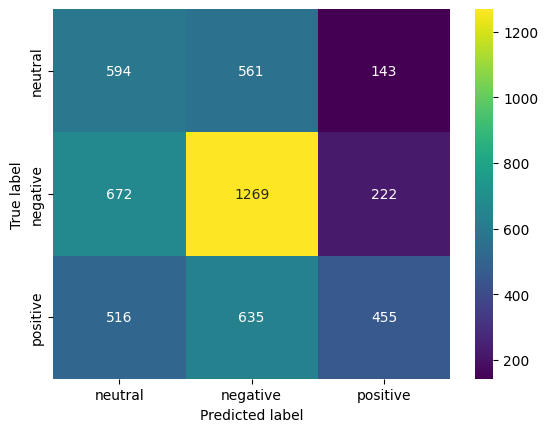

In [137]:
cf_matrix = confusion_matrix(y_true=Ytest, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* Logistic Regression

In [138]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000,solver='saga')
clf.fit(Xtrain, Ytrain)
y_pred=clf.predict(Xtest)

In [139]:
print(classification_report(y_true=Ytest, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.33      0.45      0.38      1298
    negative       0.52      0.58      0.55      2163
    positive       0.55      0.30      0.39      1606

    accuracy                           0.46      5067
   macro avg       0.47      0.44      0.44      5067
weighted avg       0.48      0.46      0.45      5067



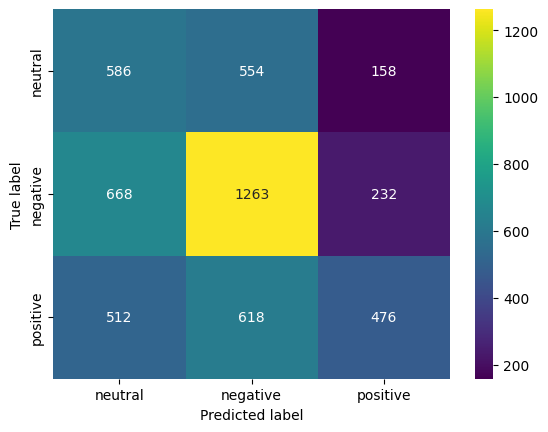

In [140]:
cf_matrix = confusion_matrix(y_true=Ytest, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* MLP

In [141]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=1000, activation = 'relu', solver='adam', random_state=1)
clf.fit(Xtrain, Ytrain)
y_pred=clf.predict(Xtest)

In [142]:
print(classification_report(y_true=Ytest, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.35      0.39      0.37      1298
    negative       0.51      0.64      0.57      2163
    positive       0.52      0.30      0.38      1606

    accuracy                           0.47      5067
   macro avg       0.46      0.44      0.44      5067
weighted avg       0.47      0.47      0.46      5067



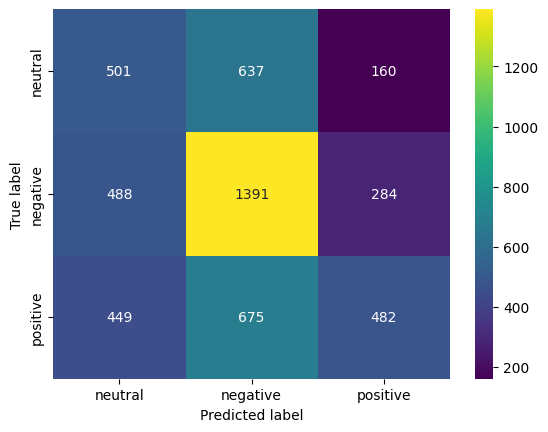

In [143]:
cf_matrix = confusion_matrix(y_true=Ytest, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# C) Pre-trained Model : Bert

**`BERT` (Bidirectional Encoder Representations from Transformers)** is a transformer-based deep learning model that uses a bidirectional attention mechanism to encode the context of words in a sentence. BERT is trained on a large corpus of text data to predict missing words in a sentence, and it uses this task to learn contextual representations of words. BERT is a more powerful and sophisticated method for representing words, as it takes into account the context in which words appear, but it is also more computationally intensive and requires more data to train.


In [144]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import AdamW

In [145]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [146]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

In [147]:
train_texts = training_data['sentences'].tolist()
train_labels = training_data['sentiment'].tolist()

valid_texts = valid_data['sentences'].tolist()
valid_labels = valid_data['sentiment'].tolist()

test_texts = test_data['sentences'].tolist()
test_labels = test_data['sentiment'].tolist()

In [148]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

In [149]:
import torch

class MSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MSDataset(train_encodings, train_labels)
valid_dataset = MSDataset(valid_encodings, valid_labels)
test_dataset = MSDataset(test_encodings, test_labels)

In [150]:
from transformers import AutoModel, AdamW
from torch import nn

class TextClassifier(nn.Module):
  def __init__(self):
    super(TextClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained('bert-base-uncased')
    self.fc1 = nn.Linear(768, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 3)
    self.activation = nn.ReLU()
  
  def forward(self, input_ids, attention_mask):
    bert = self.bert(input_ids, attention_mask=attention_mask)[1]
    fc1 = self.fc1(bert)
    fc1 = self.activation(fc1)
    fc2 = self.fc2(fc1)
    fc2 = self.activation(fc2)
    fc3 = self.fc3(fc2)
    return bert,fc1,fc2,fc3

In [151]:
model = TextClassifier()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TextClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [152]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

learning_rate = 5e-4
optim = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=15, eta_min=5e-5, last_epoch=-1)
loss_func = nn.CrossEntropyLoss().to(device)
     

In [153]:
for p in model.bert.parameters():
    p.requires_grad = False

In [154]:
from tqdm import tqdm
def train_loop(epoch, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.train()
    with tqdm(dataloader, unit="batch") as tepoch:
        for item in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            optimizer.zero_grad()
            size_batch = item['labels'].size()[0]
            # Compute prediction and loss
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            labels = item['labels'].to(device)
            _,_,_,outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            avgLoss += loss.item()
            correct = (outputs.argmax(1) == labels).type(torch.float).sum().item()
            avgCorrect += correct
            
            # Backpropagation
            
            loss.backward()
            optimizer.step()
    
            correct = correct / size_batch
            
            tepoch.set_postfix(batch_loss=loss.item(), batch_accuracy=100. * correct)
            
    avgLoss /= len(dataloader)
    avgCorrect /= size
    print(f" -Training Accuracy (Avg) = {(100*avgCorrect):>0.1f}%, loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

def test_loop(dataloader, model, loss_fn, error):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.eval()
    with torch.no_grad():
        for item in dataloader:
            # Compute prediction and loss
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            labels = item['labels'].to(device)
            _,_,_,outputs = model(input_ids, attention_mask=attention_mask)
            avgLoss += loss_fn(outputs, labels).item()
            avgCorrect += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    avgLoss /= len(dataloader)
    avgCorrect /= size
    print(f" -{error} : Accuracy = {(100*avgCorrect):>0.1f}%, loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

In [155]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='tensorboard/Bert')

epochs = 30
for e in range(epochs):
    print(f" Epoch {e+1} -------------------------------")
    trainAcc, trainLoss = train_loop(e, train_loader, model, loss_func, optim)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_loader, model, loss_func, 'validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    scheduler.step()
    
print("Done!")

 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 159/159 [00:08<00:00, 19.48batch/s, batch_accuracy=56.2, batch_loss=0.959]


 -Training Accuracy (Avg) = 44.4%, loss = 1.055541 

 -validation : Accuracy = 44.5%, loss = 1.063850 

 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 159/159 [00:08<00:00, 19.27batch/s, batch_accuracy=81.2, batch_loss=0.759]


 -Training Accuracy (Avg) = 50.9%, loss = 0.989097 

 -validation : Accuracy = 50.4%, loss = 0.982765 

 Epoch 3 -------------------------------


Epoch 3: 100%|██████████| 159/159 [00:08<00:00, 19.23batch/s, batch_accuracy=56.2, batch_loss=1.03] 


 -Training Accuracy (Avg) = 52.7%, loss = 0.970922 

 -validation : Accuracy = 49.9%, loss = 1.023307 

 Epoch 4 -------------------------------


Epoch 4: 100%|██████████| 159/159 [00:08<00:00, 19.14batch/s, batch_accuracy=37.5, batch_loss=1.07] 


 -Training Accuracy (Avg) = 54.7%, loss = 0.951268 

 -validation : Accuracy = 54.1%, loss = 0.958944 

 Epoch 5 -------------------------------


Epoch 5: 100%|██████████| 159/159 [00:08<00:00, 19.18batch/s, batch_accuracy=50, batch_loss=0.983]  


 -Training Accuracy (Avg) = 55.4%, loss = 0.941184 

 -validation : Accuracy = 53.3%, loss = 0.971758 

 Epoch 6 -------------------------------


Epoch 6: 100%|██████████| 159/159 [00:08<00:00, 19.13batch/s, batch_accuracy=56.2, batch_loss=0.939]


 -Training Accuracy (Avg) = 55.7%, loss = 0.936724 

 -validation : Accuracy = 53.1%, loss = 0.962234 

 Epoch 7 -------------------------------


Epoch 7: 100%|██████████| 159/159 [00:08<00:00, 19.08batch/s, batch_accuracy=56.2, batch_loss=0.932]


 -Training Accuracy (Avg) = 55.5%, loss = 0.936940 

 -validation : Accuracy = 55.6%, loss = 0.931059 

 Epoch 8 -------------------------------


Epoch 8: 100%|██████████| 159/159 [00:08<00:00, 19.03batch/s, batch_accuracy=62.5, batch_loss=0.979]


 -Training Accuracy (Avg) = 56.5%, loss = 0.923106 

 -validation : Accuracy = 54.6%, loss = 0.962748 

 Epoch 9 -------------------------------


Epoch 9: 100%|██████████| 159/159 [00:08<00:00, 18.98batch/s, batch_accuracy=56.2, batch_loss=0.812]


 -Training Accuracy (Avg) = 56.8%, loss = 0.918808 

 -validation : Accuracy = 56.8%, loss = 0.916911 

 Epoch 10 -------------------------------


Epoch 10: 100%|██████████| 159/159 [00:08<00:00, 18.93batch/s, batch_accuracy=56.2, batch_loss=1.05] 


 -Training Accuracy (Avg) = 56.9%, loss = 0.922647 

 -validation : Accuracy = 55.6%, loss = 0.935646 

 Epoch 11 -------------------------------


Epoch 11: 100%|██████████| 159/159 [00:08<00:00, 18.92batch/s, batch_accuracy=50, batch_loss=0.991]  


 -Training Accuracy (Avg) = 57.6%, loss = 0.915350 

 -validation : Accuracy = 57.0%, loss = 0.924545 

 Epoch 12 -------------------------------


Epoch 12: 100%|██████████| 159/159 [00:08<00:00, 18.93batch/s, batch_accuracy=50, batch_loss=0.999]  


 -Training Accuracy (Avg) = 57.7%, loss = 0.910397 

 -validation : Accuracy = 56.3%, loss = 0.923436 

 Epoch 13 -------------------------------


Epoch 13: 100%|██████████| 159/159 [00:08<00:00, 18.94batch/s, batch_accuracy=62.5, batch_loss=1.01] 


 -Training Accuracy (Avg) = 58.1%, loss = 0.909171 

 -validation : Accuracy = 57.5%, loss = 0.914523 

 Epoch 14 -------------------------------


Epoch 14: 100%|██████████| 159/159 [00:08<00:00, 18.96batch/s, batch_accuracy=75, batch_loss=0.652]  


 -Training Accuracy (Avg) = 57.8%, loss = 0.905628 

 -validation : Accuracy = 57.6%, loss = 0.915343 

 Epoch 15 -------------------------------


Epoch 15: 100%|██████████| 159/159 [00:08<00:00, 18.98batch/s, batch_accuracy=56.2, batch_loss=0.863]


 -Training Accuracy (Avg) = 58.0%, loss = 0.906412 

 -validation : Accuracy = 57.1%, loss = 0.916432 

 Epoch 16 -------------------------------


Epoch 16: 100%|██████████| 159/159 [00:08<00:00, 18.94batch/s, batch_accuracy=62.5, batch_loss=0.865]


 -Training Accuracy (Avg) = 57.7%, loss = 0.904707 

 -validation : Accuracy = 57.2%, loss = 0.915437 

 Epoch 17 -------------------------------


Epoch 17: 100%|██████████| 159/159 [00:08<00:00, 18.91batch/s, batch_accuracy=81.2, batch_loss=0.778]


 -Training Accuracy (Avg) = 58.4%, loss = 0.900719 

 -validation : Accuracy = 56.3%, loss = 0.933622 

 Epoch 18 -------------------------------


Epoch 18: 100%|██████████| 159/159 [00:08<00:00, 18.93batch/s, batch_accuracy=75, batch_loss=0.702]  


 -Training Accuracy (Avg) = 57.9%, loss = 0.904574 

 -validation : Accuracy = 57.4%, loss = 0.918121 

 Epoch 19 -------------------------------


Epoch 19: 100%|██████████| 159/159 [00:08<00:00, 18.90batch/s, batch_accuracy=68.8, batch_loss=0.922]


 -Training Accuracy (Avg) = 57.5%, loss = 0.910927 

 -validation : Accuracy = 56.9%, loss = 0.927140 

 Epoch 20 -------------------------------


Epoch 20: 100%|██████████| 159/159 [00:08<00:00, 18.90batch/s, batch_accuracy=75, batch_loss=0.668]  


 -Training Accuracy (Avg) = 57.7%, loss = 0.906113 

 -validation : Accuracy = 57.1%, loss = 0.920044 

 Epoch 21 -------------------------------


Epoch 21: 100%|██████████| 159/159 [00:08<00:00, 18.81batch/s, batch_accuracy=50, batch_loss=0.967]  


 -Training Accuracy (Avg) = 58.0%, loss = 0.905603 

 -validation : Accuracy = 55.8%, loss = 0.935273 

 Epoch 22 -------------------------------


Epoch 22: 100%|██████████| 159/159 [00:08<00:00, 18.86batch/s, batch_accuracy=68.8, batch_loss=0.737]


 -Training Accuracy (Avg) = 58.1%, loss = 0.903440 

 -validation : Accuracy = 56.7%, loss = 0.921045 

 Epoch 23 -------------------------------


Epoch 23: 100%|██████████| 159/159 [00:08<00:00, 18.85batch/s, batch_accuracy=43.8, batch_loss=1.12] 


 -Training Accuracy (Avg) = 57.6%, loss = 0.913298 

 -validation : Accuracy = 56.9%, loss = 0.925996 

 Epoch 24 -------------------------------


Epoch 24: 100%|██████████| 159/159 [00:08<00:00, 18.88batch/s, batch_accuracy=37.5, batch_loss=0.9]  


 -Training Accuracy (Avg) = 57.4%, loss = 0.912951 

 -validation : Accuracy = 56.9%, loss = 0.919070 

 Epoch 25 -------------------------------


Epoch 25: 100%|██████████| 159/159 [00:08<00:00, 18.89batch/s, batch_accuracy=56.2, batch_loss=0.859]


 -Training Accuracy (Avg) = 57.2%, loss = 0.915273 

 -validation : Accuracy = 54.9%, loss = 0.934967 

 Epoch 26 -------------------------------


Epoch 26: 100%|██████████| 159/159 [00:08<00:00, 18.90batch/s, batch_accuracy=62.5, batch_loss=0.89] 


 -Training Accuracy (Avg) = 57.6%, loss = 0.910598 

 -validation : Accuracy = 55.4%, loss = 0.932303 

 Epoch 27 -------------------------------


Epoch 27: 100%|██████████| 159/159 [00:08<00:00, 18.86batch/s, batch_accuracy=68.8, batch_loss=0.716]


 -Training Accuracy (Avg) = 57.5%, loss = 0.908339 

 -validation : Accuracy = 56.7%, loss = 0.917546 

 Epoch 28 -------------------------------


Epoch 28: 100%|██████████| 159/159 [00:08<00:00, 18.88batch/s, batch_accuracy=75, batch_loss=0.679]  


 -Training Accuracy (Avg) = 57.8%, loss = 0.907113 

 -validation : Accuracy = 57.1%, loss = 0.928348 

 Epoch 29 -------------------------------


Epoch 29: 100%|██████████| 159/159 [00:08<00:00, 18.88batch/s, batch_accuracy=50, batch_loss=0.92]   


 -Training Accuracy (Avg) = 57.5%, loss = 0.911744 

 -validation : Accuracy = 57.5%, loss = 0.905603 

 Epoch 30 -------------------------------


Epoch 30: 100%|██████████| 159/159 [00:08<00:00, 18.88batch/s, batch_accuracy=50, batch_loss=1.01]   


 -Training Accuracy (Avg) = 58.0%, loss = 0.904811 

 -validation : Accuracy = 56.7%, loss = 0.922954 

Done!


In [156]:
test_loop(test_loader, model, loss_func, 'Test');

 -Test : Accuracy = 60.8%, loss = 0.883162 



In [157]:
y_pred = []
y_true = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        _,_,_,outputs = model(input_ids, attention_mask=attention_mask)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())

100%|██████████| 40/40 [00:02<00:00, 19.11it/s]


In [158]:
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.52      0.41      0.46      1298
    negative       0.64      0.77      0.70      2163
    positive       0.62      0.55      0.58      1606

    accuracy                           0.61      5067
   macro avg       0.59      0.58      0.58      5067
weighted avg       0.60      0.61      0.60      5067



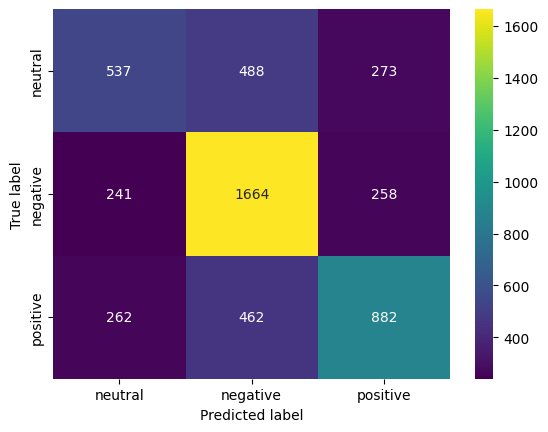

In [159]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [161]:
torch.save(model.state_dict(), 'checkpoints/bert.pth')

# Analysis and Comparison

> **Best Model** -> `BERT`
> * Validation Accuracy : 57%
> * Test Accuracy : 61%
> * Best f1-score : 70%

> * In summary, `GloVe` is a fast and efficient method for creating word embeddings, while `BERT` is a more powerful and sophisticated method that takes into account the context of words in a sentence. The choice between `GloVe` and `BERT` depends on the specific NLP task and the available computational resources.
> * `Word2vec` is a predictive model that uses context to generate vectors for words. `TF-IDF`, on the other hand, is a statistical method that assigns a score to each word in a document, based on how important it is to the overall document. `Word2vec` is typically used to generate semantic representations of words, while `TF-IDF` is used to determine the importance of words within a document. In comparison, `Word2vec` is more suited to understanding the meaning of words, while `TF-IDF` is better at determining the importance of words in a document.

> * `Glove` word embeddings are context independent- these models output just one vector (embedding) for each word, combining all the different senses of the word into one vector. That is the one numeric representation of a word regardless of where the words occurs in a sentence and regardless of the different meanings they may have.
> * `BERT` can generate different word embeddings for a word that captures the context of a word - that is its position in a sentence. BERT uses Transformer an attention based model with positional encodings to represent word positions
> * we can use `word2vec` and `Glove` vectors trained on a large corpus directly for downstream tasks. All we need is the vectors for the words. There is no need for the model itself that was used to train these vectors.
> * in the case of `BERT`, since they are context dependent, we need the model that was used to train the vectors even after training, since the models generate the vectors for a word based on context.